In [ ]:
from google.colab import drive
import os
# Mount Google Drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/NCS
path = os.getcwd()
print(path)

Mounted at /content/gdrive
/content/gdrive/MyDrive/NCS
/content/gdrive/MyDrive/NCS


In [ ]:
!pip install lime
!pip install xgboost
!pip install boruta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=9c86f725d0de72676587ae4a6a1098a627a6dafda64e271ac9e02f8647598121
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 2.9 MB/s eta 0:00:00


In [ ]:
# Tạo 15 thư mục tương ứng
folder_names = [
    "20685", "20711", "21050", "21122", "29354", "30784", "31312",
    "31552", "32537", "33315", "36895", "37364", "39582", "39716", "44077"]

path1 = path+'/Thuc Nghiem/Selected Features/Results/01.07.BestF/'
# Tạo các thư mục trực tiếp trong Google Drive
for folder_name in folder_names:
    folder_path = os.path.join(path1, folder_name)
    os.makedirs(folder_path, exist_ok=True)

print("Tạo thành công 15 thư mục trên Google Drive.")


Tạo thành công 15 thư mục trên Google Drive.


Processed dataset 20685: (327, 54627)
Processed dataset 20711: (90, 54675)
Processed dataset 21050: (310, 54613)
Processed dataset 21122: (158, 22283)
Processed dataset 29354: (53, 22215)
Processed dataset 30784: (229, 54675)
Processed dataset 31312: (498, 54630)
Processed dataset 31552: (111, 33297)
Processed dataset 32537: (217, 11950)
Processed dataset 33315: (575, 22283)
Processed dataset 36895: (76, 54675)
Processed dataset 37364: (94, 54675)
Processed dataset 39582: (566, 54675)
Processed dataset 39716: (53, 33297)
Processed dataset 44077: (226, 33252)

Label counts have been successfully saved to 'Thuc Nghiem/Selected Features/Results/28.10_Tke/label_counts.csv'.


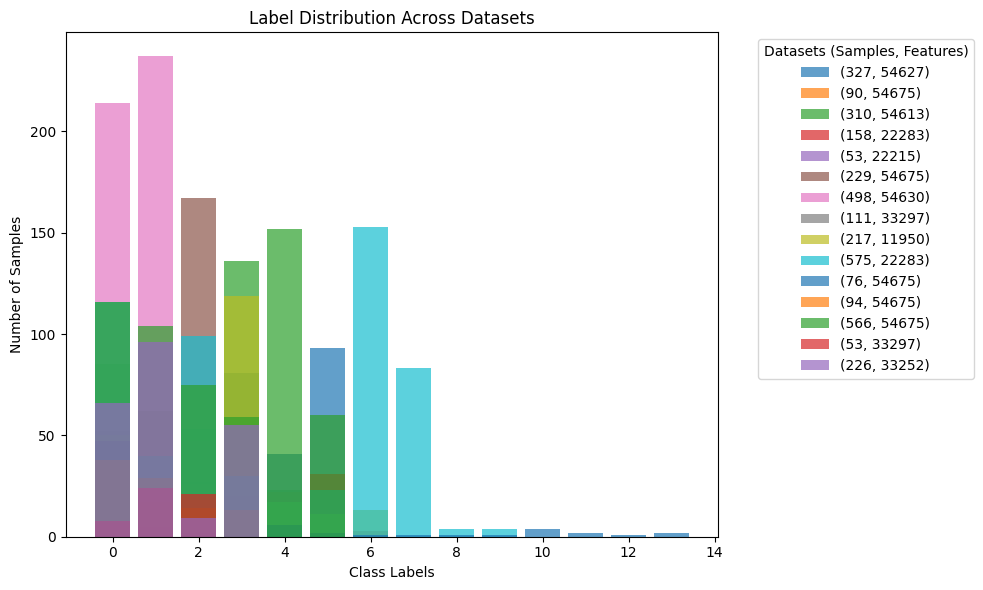

In [ ]:
# Code này dùng trực quan hóa phân bổ lớp tất cả dataset trên cùng 1 biểu đồ
import gzip
import pandas as pd
import os
import matplotlib.pyplot as plt
from google.colab import drive

datasets = [
    20685, 20711, 21050, 21122, 29354, 30784,
    31312, 31552, 32537, 33315, 36895, 37364,
    39582, 39716, 44077
]

base_folder = 'Gene Data'

class_labels = list(range(14))
counts_dict = {'Lớp': class_labels}

for dataset_id in datasets:
    file_path = os.path.join(base_folder, str(dataset_id), 'data.trn.gz')
    if not os.path.isfile(file_path):
        print(f"File not found: {file_path}. Skipping this dataset.")
        continue

    try:
        with gzip.open(file_path, 'rt') as f:
            df = pd.read_csv(f, header=None, sep='\s+')
        X = df.iloc[:, :-1]
        y = df.iloc[:, -1]
        label_counts = y.value_counts().sort_index()
        num_samples, num_features = df.shape
        num_features -= 1
        column_name = f"({num_samples}, {num_features})"
        counts = [label_counts.get(label, None) for label in class_labels]
        counts_dict[column_name] = counts

        print(f"Processed dataset {dataset_id}: {column_name}")

    except Exception as e:
        print(f"An error occurred while processing {file_path}: {e}")
        continue
df_counts = pd.DataFrame(counts_dict)
df_counts = df_counts.sort_values(by='Lớp')
output_directory = 'Thuc Nghiem/Selected Features/Results/28.10_Tke/'
os.makedirs(output_directory, exist_ok=True)
output_csv = os.path.join(output_directory, 'label_counts.csv')
df_counts.to_csv(output_csv, index=False, encoding='utf-8-sig')

print(f"\nLabel counts have been successfully saved to '{output_csv}'.")
df_verify = pd.read_csv(output_csv)
plt.figure(figsize=(10, 6))
for column in df_counts.columns[1:]:
    plt.bar(df_counts['Lớp'], df_counts[column], alpha=0.7, label=column)

plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.title('Label Distribution Across Datasets')
plt.legend(title='Datasets (Samples, Features)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


1.   **Bước 1**: Chọn đặc trưng với Boruta
2.   **Bước 2**: Dùng các đặc trưng đã chọn train với SVM, RF, XGBoost,

In [ ]:
## 01.07.2025 Boruta Perc=100, alpha=0.01

import os
import logging
import warnings
import pandas as pd
import time
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

# Bỏ qua cảnh báo
warnings.filterwarnings('ignore')

datasets = [20685,20711, 21050, 21122, 29354, 30784, 31312, 31552, 32537, 33315, 36895, 37364, 39582, 39716, 44077]
folders='01.07.BestF'
def load_data(file_path):
    try:
        df = pd.read_csv(file_path, header=None, sep='\s+')
        logging.info(f"Đọc dữ liệu từ file: {file_path}")
        return df
    except FileNotFoundError:
        logging.error(f"Không tìm thấy file: {file_path}")
        return None

# Hàm chuẩn hóa dữ liệu
def scale_data(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    logging.info("Dữ liệu đã được chuẩn hóa.")
    return X_scaled

# Hàm lựa chọn đặc trưng bằng Boruta
def select_features_with_boruta(X_scaled, y):
    rf = RandomForestClassifier(n_estimators=200, random_state=42)
    boruta_selector = BorutaPy(
        rf,
        n_estimators=300,
        max_iter=200,
        alpha=0.01,
        perc=100,
        two_step=True,
        random_state=42,
        verbose=1
    )
    start_time = time.time()
    boruta_selector.fit(X_scaled, y)
    end_time = time.time()

    feature_selection_time = end_time - start_time
    logging.info(f"Thời gian trích đặc trưng bằng Boruta: {feature_selection_time:.2f} giây")
    print(f"Thời gian trích đặc trưng bằng Boruta: {feature_selection_time:.2f} giây")

    X_selected = X_scaled[:, boruta_selector.support_]
    num_selected_features = boruta_selector.support_.sum()
    logging.info(f"Số đặc trưng được chọn: {num_selected_features}")
    return X_selected, boruta_selector, num_selected_features, feature_selection_time

# Lưu tên đặc trưng đã chọn vào file CSV
def save_selected_feature_names_to_csv(X, selected_features, output_directory, filename='selected_feature_names.csv'):
    selected_feature_names = X.columns[selected_features]
    selected_features_file = os.path.join(output_directory, filename)
    pd.DataFrame(selected_feature_names, columns=['Selected Features']).to_csv(selected_features_file, index=False)
    logging.info(f"Tên các đặc trưng đã được chọn lưu vào file: {selected_features_file}")
    print(f"Tên các đặc trưng đã được chọn lưu vào file: {selected_features_file}")

# Lưu kết quả Boruta vào file CSV
def save_boruta_summary_to_csv(boruta_selector, feature_selection_time, output_directory, filename='boruta_summary.csv'):
    # Đếm số lượng Confirmed, Tentative và Rejected
    confirmed_count = boruta_selector.support_.sum()
    tentative_count = boruta_selector.support_weak_.sum()
    rejected_count = (~(boruta_selector.support_ | boruta_selector.support_weak_)).sum()

    # Tạo DataFrame để lưu kết quả tổng quát
    summary_df = pd.DataFrame({
        'Confirmed': [confirmed_count],
        'Tentative': [tentative_count],
        'Rejected': [rejected_count],
        'Feature Selection Time (s)': [feature_selection_time]
    })

    # Lưu DataFrame vào file CSV
    summary_file = os.path.join(output_directory, filename)
    summary_df.to_csv(summary_file, index=False)
    logging.info(f"Tổng kết Boruta được lưu vào file: {summary_file}")
    print(f"Tổng kết Boruta được lưu vào file: {summary_file}")

# Selected features and save results in CSV
all_results = pd.DataFrame(columns=['Dataset', 'Confirmed', 'Tentative', 'Rejected', 'Feature Selection Time (s)'])
for dataset in datasets:
    file_path = f'Gene Data/{dataset}/data.trn.gz'

    output_directory = os.path.join('Thuc Nghiem', 'Selected Features', 'Results', folders, str(dataset))

    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    #  logging
    log_file = os.path.join(output_directory, 'experiment_log.log')
    logging.basicConfig(filename=log_file, level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

    # Write  log
    logging.info(f"Bắt đầu quá trình chọn lọc đặc trưng với Boruta cho dataset: {dataset}.")

    #Load dataset
    df = load_data(file_path)
    if df is not None:
        X = df.iloc[:, :-1]
        y = df.iloc[:, -1]
        X_scaled = scale_data(X)


        X_selected, boruta_selector, num_selected_features, feature_selection_time = select_features_with_boruta(X_scaled, y)
        print(f"Số đặc trưng được chọn cho dataset {dataset}: {num_selected_features}")


        save_selected_feature_names_to_csv(X, boruta_selector.support_, output_directory)


        save_boruta_summary_to_csv(boruta_selector, feature_selection_time, output_directory)


        confirmed_count = boruta_selector.support_.sum()
        tentative_count = boruta_selector.support_weak_.sum()
        rejected_count = (~(boruta_selector.support_ | boruta_selector.support_weak_)).sum()


        all_results = pd.concat([all_results, pd.DataFrame([{
            'Dataset': dataset,
            'Confirmed': confirmed_count,
            'Tentative': tentative_count,
            'Rejected': rejected_count,
            'Feature Selection Time (s)': feature_selection_time
        }])], ignore_index=True)


output_all_file = os.path.join('Thuc Nghiem', 'Selected Features', 'Results',folders, 'ALL_boruta_summary.csv')
all_results.to_csv(output_all_file, index=False)
logging.info(f"Kết quả tổng hợp Boruta cho tất cả các dataset được lưu vào file: {output_all_file}")
print(f"Kết quả tổng hợp Boruta cho tất cả các dataset được lưu vào file: {output_all_file}")


Iteration: 1 / 200
Iteration: 2 / 200
Iteration: 3 / 200
Iteration: 4 / 200
Iteration: 5 / 200
Iteration: 6 / 200
Iteration: 7 / 200
Iteration: 8 / 200
Iteration: 9 / 200
Iteration: 10 / 200
Iteration: 11 / 200
Iteration: 12 / 200
Iteration: 13 / 200
Iteration: 14 / 200
Iteration: 15 / 200
Iteration: 16 / 200
Iteration: 17 / 200
Iteration: 18 / 200
Iteration: 19 / 200
Iteration: 20 / 200
Iteration: 21 / 200
Iteration: 22 / 200
Iteration: 23 / 200
Iteration: 24 / 200
Iteration: 25 / 200
Iteration: 26 / 200
Iteration: 27 / 200
Iteration: 28 / 200
Iteration: 29 / 200
Iteration: 30 / 200
Iteration: 31 / 200
Iteration: 32 / 200
Iteration: 33 / 200
Iteration: 34 / 200
Iteration: 35 / 200
Iteration: 36 / 200
Iteration: 37 / 200
Iteration: 38 / 200
Iteration: 39 / 200
Iteration: 40 / 200
Iteration: 41 / 200
Iteration: 42 / 200
Iteration: 43 / 200
Iteration: 44 / 200
Iteration: 45 / 200
Iteration: 46 / 200
Iteration: 47 / 200
Iteration: 48 / 200
Iteration: 49 / 200
Iteration: 50 / 200
Iteration

In [ ]:
# đọc file ALL_boruta_summary.csv
path1 = path+'/Thuc Nghiem/Selected Features/Results/01.07.BestF'
df_boruta = pd.read_csv(path1+"/ALL_boruta_summary.csv")
df_boruta


,Dataset,Confirmed,Tentative,Rejected,Feature Selection Time (s)
0,20685,545,262,53820,633.020502
1,20711,111,33,54531,140.012034
2,21050,72,17,54524,350.332310
3,21122,271,124,21888,219.237104
4,29354,28,3,22184,91.597598
5,30784,171,64,54440,279.928258
6,31312,213,42,54375,777.705729
7,31552,79,48,33170,136.972853
8,32537,96,17,11837,232.654213
9,33315,483,108,21692,1176.811348


In [ ]:
# sử dụng LIME tính đọ quan trong các features trên tất cả datasets
import os
import lime
import lime.lime_tabular
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


datasets = ['20685', '20711', '21050', '21122', '29354', '30784', '31312', '31552', '32537', '33315', '36895', '37364', '39582', '39716', '44077']
folder = "01.07.BestF"


# Thiết lập số lượng mẫu hợp lý cho LIME
num_samples = 10000


for dataset in datasets:
    print(f"Processing dataset {dataset}...")

    # Đọc file các đặc trưng đã chọn
    selected_features_file = os.path.join('Thuc Nghiem', 'Selected Features', 'Results', folder, dataset, 'selected_feature_names.csv')
    if not os.path.exists(selected_features_file):
        print(f"File {selected_features_file} không tồn tại, bỏ qua dataset {dataset}")
        continue

    selected_features = pd.read_csv(selected_features_file)['Selected Features'].values

    # Đọc dữ liệu từ file
    file_path = f'Gene Data/{dataset}/data.trn.gz'
    if not os.path.exists(file_path):
        print(f"File {file_path} không tồn tại, bỏ qua dataset {dataset}")
        continue

    df = pd.read_csv(file_path, header=None, sep='\s+')
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    #map features
    X_selected = X[selected_features]

    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

    rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
    rf_model.fit(X_train, y_train)

    # Khởi tạo LIME explainer với discretize_continuous=False
    explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_train.values,
        feature_names=selected_features,
        class_names=np.unique(y_train).astype(str),
        mode='classification',
        discretize_continuous=False
    )
    num_features = len(selected_features)

    aggregate_importance_df = pd.DataFrame(columns=selected_features)
    for i in range(len(X_test)):
        # Giải thích từng mẫu đơn lẻ
        lime_explanation = explainer.explain_instance(
            X_test.iloc[i].values,
            rf_model.predict_proba,
            num_samples=num_samples,
            num_features=num_features
        )
        # Độ quan trọng của đặc trưng từ LIME mỗi mẫu
        lime_importance = dict(lime_explanation.as_list())

        # Kiểm tra xem đặc trưng nào được LIME giải thích và ghi lại kết quả
        for feature in selected_features:
            if feature in lime_importance:
                aggregate_importance_df.at[i, feature] = lime_importance[feature]
            else:
                aggregate_importance_df.at[i, feature] = 0

    mean_importance_df = aggregate_importance_df.mean().reset_index()
    mean_importance_df.columns = ['Feature', 'Mean Importance']
    mean_importance_df['Absolute Importance'] = mean_importance_df['Mean Importance'].abs()
    mean_importance_df = mean_importance_df.sort_values(by='Absolute Importance', ascending=False)
    output_folder = os.path.join('Thuc Nghiem', 'Selected Features', 'Results', folder, dataset)
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    lime_cleaned_output_file = os.path.join(output_folder, 'lime_mean_feature_importance.csv')
    mean_importance_df.to_csv(lime_cleaned_output_file, index=False)

    print(f"Kết quả độ quan trọng trung bình của LIME cho dataset {dataset} đã được lưu vào: {lime_cleaned_output_file}")


Processing dataset 20685...
Kết quả độ quan trọng trung bình của LIME cho dataset 20685 đã được lưu vào: Thuc Nghiem/Selected Features/Results/01.07.BestF/20685/lime_mean_feature_importance.csv
Processing dataset 20711...
Kết quả độ quan trọng trung bình của LIME cho dataset 20711 đã được lưu vào: Thuc Nghiem/Selected Features/Results/01.07.BestF/20711/lime_mean_feature_importance.csv
Processing dataset 21050...
Kết quả độ quan trọng trung bình của LIME cho dataset 21050 đã được lưu vào: Thuc Nghiem/Selected Features/Results/01.07.BestF/21050/lime_mean_feature_importance.csv
Processing dataset 21122...
Kết quả độ quan trọng trung bình của LIME cho dataset 21122 đã được lưu vào: Thuc Nghiem/Selected Features/Results/01.07.BestF/21122/lime_mean_feature_importance.csv
Processing dataset 29354...
Kết quả độ quan trọng trung bình của LIME cho dataset 29354 đã được lưu vào: Thuc Nghiem/Selected Features/Results/01.07.BestF/29354/lime_mean_feature_importance.csv
Processing dataset 30784...
Kế

In [ ]:
# Huấn luyện SVM dựa trên Test F1 Score và chỉ lưu lại mô hình có điểm cao nhất.
# Lưu lại feature có F1 score lớn nhất
import os
import pandas as pd
import logging
import time
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline


logging.basicConfig(level=logging.INFO)

datasets = [20711, 21050, 21122, 29354, 30784, 31312, 31552, 32537, 33315, 36895, 37364, 39582, 39716, 44077]

folders='01.07.BestF'
def get_svm_model():
    return SVC(C=100000, kernel='rbf', gamma='scale', class_weight='balanced', random_state=42)


for dataset in datasets:
    logging.info(f"Đang xử lý dataset: {dataset}")
    print(f"Đang xử lý dataset: {dataset}")

    start_dataset_time = time.time()
    lime_mean_importance_file = os.path.join(
        'Thuc Nghiem', 'Selected Features', 'Results', folder, str(dataset), 'lime_mean_feature_importance.csv'
    )

    if not os.path.exists(lime_mean_importance_file):
        logging.error(f"Không tìm thấy file {lime_mean_importance_file}, bỏ qua dataset {dataset} - Lý do: File LIME không tồn tại.")
        continue

    lime_importance_df = pd.read_csv(lime_mean_importance_file)
    total_features = lime_importance_df['Feature'].nunique()

    file_path = os.path.join('Gene Data', str(dataset), 'data.trn.gz')
    if not os.path.exists(file_path):
        logging.error(f"Không tìm thấy file {file_path}, bỏ qua dataset {dataset} - Lý do: File dữ liệu không tồn tại.")
        continue

    df = pd.read_csv(file_path, header=None, sep='\s+')
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    class_counts = y.value_counts()
    classes_to_keep = class_counts[class_counts >= 2].index
    if len(classes_to_keep) < 2:
        logging.error(f"Sau khi loại bỏ các lớp ít xuất hiện, không đủ lớp để phân loại trong dataset {dataset} - Lý do: Không đủ lớp.")
        continue

    X = X[y.isin(classes_to_keep)]
    y = y[y.isin(classes_to_keep)]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    end_preprocessing_time = time.time()
    preprocessing_time = end_preprocessing_time - start_dataset_time

    best_result = None
    all_results = []  #

    for top_n_features in range(10, total_features + 1):
        top_features = lime_importance_df['Feature'].astype(int).values[:top_n_features]

        X_train_top_selected = X_train.iloc[:, top_features]
        X_test_top_selected = X_test.iloc[:, top_features]

        cv_method = KFold(n_splits=10, shuffle=True, random_state=42) if len(X_train_top_selected) > 300 else LeaveOneOut()

        pipeline_cv = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', get_svm_model())
        ])

        scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']

        start_train_time = time.time()
        cv_results = cross_validate(
            pipeline_cv, X_train_top_selected, y_train, cv=cv_method, scoring=scoring,
            n_jobs=-1, return_train_score=False
        )
        training_time = time.time() - start_train_time
        total_training_time += training_time

        accuracy_cv = cv_results['test_accuracy'].mean()
        precision_cv = cv_results['test_precision_weighted'].mean()
        recall_cv = cv_results['test_recall_weighted'].mean()
        f1_cv = cv_results['test_f1_weighted'].mean()

        pipeline_final = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', get_svm_model())
        ])

        pipeline_final.fit(X_train_top_selected, y_train)
        y_test_pred = pipeline_final.predict(X_test_top_selected)

        accuracy_test = accuracy_score(y_test, y_test_pred)
        precision_test = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
        recall_test = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)
        f1_test = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)

        current_result = {
            'Top N Features': top_n_features,
            'Test Accuracy': accuracy_test,
            'Test Precision': precision_test,
            'Test Recall': recall_test,
            'Test F1 Score': f1_test,
            'Training Time': training_time,
            'Preprocessing Time (s)': preprocessing_time,
            'Total Training Time (s)': total_training_time,
            'Dataset Processing Time (s)': time.time() - start_dataset_time
        }
        all_results.append(current_result)
        if best_result is None or current_result['Test F1 Score'] > best_result['Test F1 Score']:
            best_result = current_result

    output_folder = os.path.join('Thuc Nghiem', 'Selected Features', 'Results', folder, str(dataset))
    os.makedirs(output_folder, exist_ok=True)
    all_results_output_file = os.path.join(output_folder, f'SVM_{dataset}_All_Results.csv')
    if all_results:
        pd.DataFrame(all_results).to_csv(all_results_output_file, index=False)
        logging.info(f"Tất cả kết quả cho dataset {dataset} đã được lưu vào file SVM_All_Results.csv.")

    # Lưu kết quả tốt nhất vào file SVM_Best_CV.csv
    results_output_file = os.path.join(output_folder, f'SVM_{dataset}_Best_CV.csv')
    if best_result:
        pd.DataFrame([best_result]).to_csv(results_output_file, index=False)
        logging.info(f"Kết quả tốt nhất cho dataset {dataset} đã được lưu vào file SVM_Best_CV.csv.")
    else:
        logging.warning(f"Không có kết quả nào đủ tốt để lưu cho dataset {dataset}.")

    logging.info(f"Thời gian tiền xử lý dataset {dataset}: {preprocessing_time:.2f} giây.")
    logging.info(f"Tổng thời gian huấn luyện cho dataset {dataset}: {total_training_time:.2f} giây.")
    logging.info(f"Thời gian xử lý dataset {dataset}: {time.time() - start_dataset_time:.2f} giây.")

logging.info('Đã xử lý xong tất cả các datasets.')



Đang xử lý dataset: 20711
Đang xử lý dataset: 21050
Đang xử lý dataset: 21122
Đang xử lý dataset: 29354
Đang xử lý dataset: 30784
Đang xử lý dataset: 31312
Đang xử lý dataset: 31552
Đang xử lý dataset: 32537
Đang xử lý dataset: 33315
Đang xử lý dataset: 36895
Đang xử lý dataset: 37364
Đang xử lý dataset: 39582
Đang xử lý dataset: 39716
Đang xử lý dataset: 44077


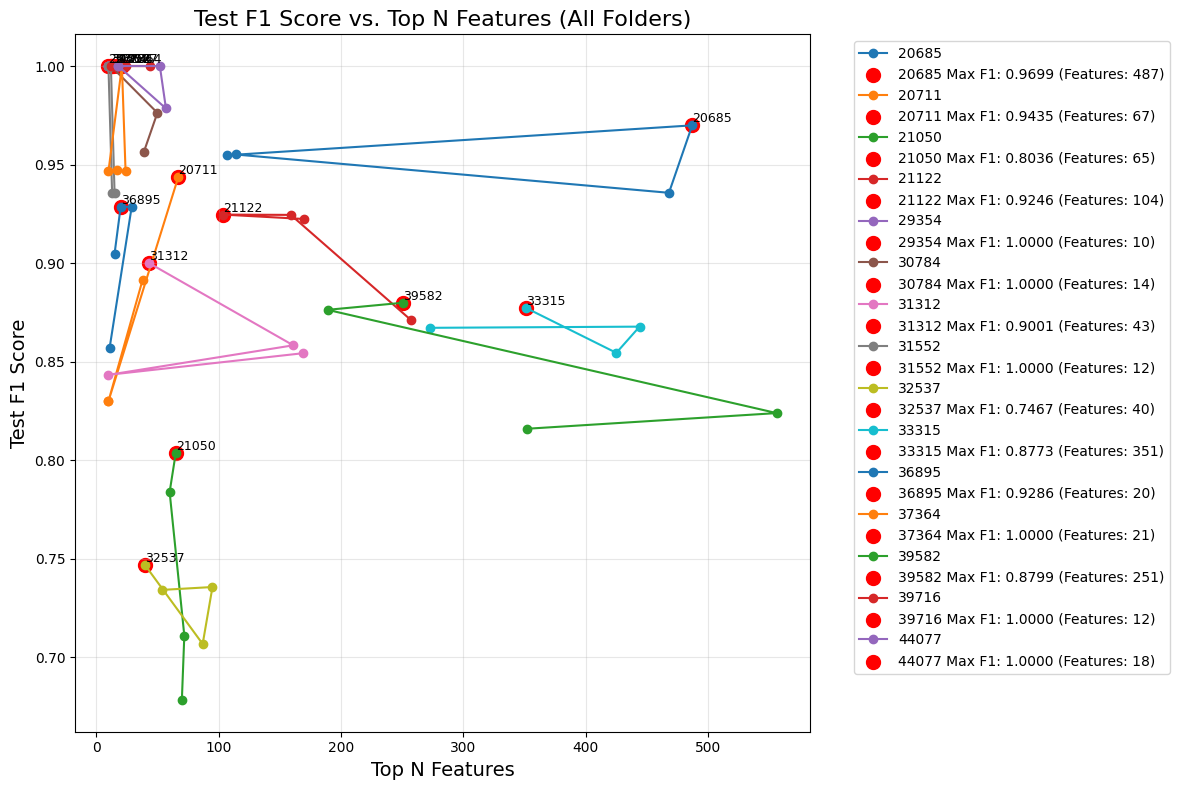

In [ ]:
## Vẽ biểu đồ qua hệ của các mô hình với F1 score cao nhất
import matplotlib.pyplot as plt
import pandas as pd
import os
path1 = 'Thuc Nghiem/Selected Features/Results/01.07.BestF'
dff_result = pd.read_csv(os.path.join(path1, "Final_Merged_Best.csv"))

folders = dff_result['Folder Name'].unique()

plt.figure(figsize=(12, 8))

for folder in folders:
    folder_data = dff_result[dff_result['Folder Name'] == folder]
    max_f1 = folder_data['Test F1 Score'].max()
    max_f1_index = folder_data['Test F1 Score'].idxmax()
    max_f1_feature = folder_data.loc[max_f1_index, 'Top N Features']
    plt.plot(folder_data['Top N Features'], folder_data['Test F1 Score'], marker='o', label=f"{folder}")
    plt.scatter(max_f1_feature, max_f1, color='red',
                label=f"{folder} Max F1: {max_f1:.4f} (Features: {int(max_f1_feature)})", s=100)
    plt.text(max_f1_feature, max_f1, f"{folder}", fontsize=9, color='black', ha='left', va='bottom')

plt.title("Test F1 Score vs. Top N Features (All Folders)", fontsize=16)
plt.xlabel("Top N Features", fontsize=14)
plt.ylabel("Test F1 Score", fontsize=14)
plt.legend(fontsize=10, loc='best', bbox_to_anchor=(1.05, 1))
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()



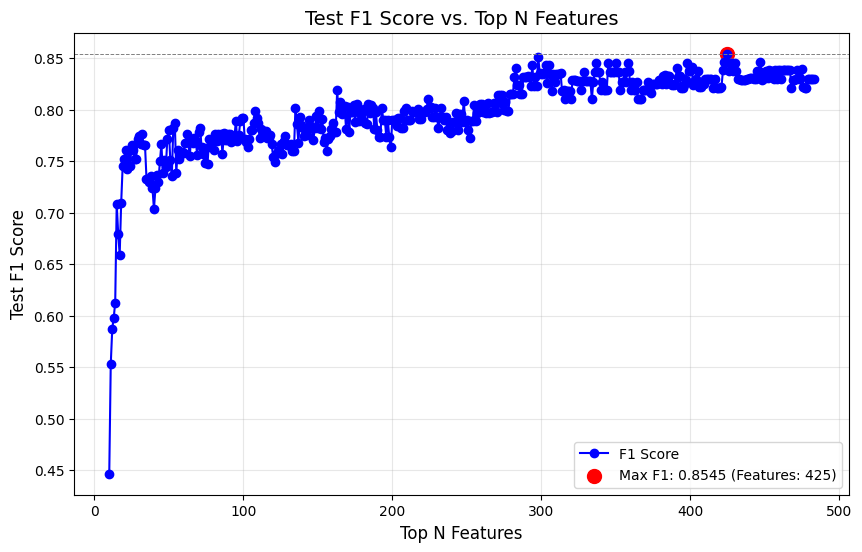

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import os

path1 = 'Thuc Nghiem/Selected Features/Results/01.07.BestF/33315'
dff_result = pd.read_csv(os.path.join(path1,"XGBoost_33315_All_Results.csv"))

max_f1 = dff_result['Test F1 Score'].max()
max_f1_index = dff_result['Test F1 Score'].idxmax()
max_f1_feature = dff_result.loc[max_f1_index, 'Top N Features']

plt.figure(figsize=(10, 6))
plt.plot(dff_result['Top N Features'], dff_result['Test F1 Score'], marker='o', label="F1 Score", color='blue')
plt.scatter(max_f1_feature, max_f1, color='red', label=f"Max F1: {max_f1:.4f} (Features: {int(max_f1_feature)})", s=100)
plt.title("Test F1 Score vs. Top N Features", fontsize=14)
plt.xlabel("Top N Features", fontsize=12)
plt.ylabel("Test F1 Score", fontsize=12)
plt.axhline(y=max_f1, color='gray', linestyle='--', linewidth=0.7)  #
plt.grid(alpha=0.3)

plt.show()


In [ ]:
# Chạy tất cả các thư mục
import matplotlib.pyplot as plt
import pandas as pd
import os

base_path = 'Thuc Nghiem/Selected Features/Results/01.07.BestF'

directories = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]

colors = [(0.8, 0.4, 0.2, 1.0), (0.5, 0.7, 0.4, 1.0), (0.1, 0.6, 0.8, 1.0), (0.7, 0.6, 0.2, 0.6), (0.5, 0.2, 0.6, 1.0)]

for dir_idx, directory in enumerate(directories):
    path1 = os.path.join(base_path, directory)

    csv_files = [file for file in os.listdir(path1) if file.endswith('_All_Results.csv')]

    plt.figure(figsize=(12, 8))
    for idx, file in enumerate(csv_files):
        file_path = os.path.join(path1, file)
        dff_result = pd.read_csv(file_path)
        max_f1 = dff_result['Test F1 Score'].max()
        max_f1_index = dff_result['Test F1 Score'].idxmax()
        max_f1_feature = dff_result.loc[max_f1_index, 'Top N Features']
        label_name = f"{file.replace('_All_Results.csv', '')}"
        plt.plot(dff_result['Top N Features'], dff_result['Test F1 Score'], marker='o',
                 label=f"{label_name}", color=colors[idx % len(colors)])

        plt.scatter(max_f1_feature, max_f1, color='red',
                    label=f"{label_name} Max F1: {max_f1:.4f} (Features: {int(max_f1_feature)})", s=100)
         plt.text(max_f1_feature, max_f1, f"{label_name}", fontsize=9, color='black', ha='right', va='bottom')

    plt.title(f"Test F1 Score vs. Top N Features ({directory})", fontsize=16)
    plt.xlabel("Top N Features", fontsize=14)
    plt.ylabel("Test F1 Score", fontsize=14)
    plt.axhline(y=max_f1, color='gray', linestyle='--', linewidth=0.7)
    plt.legend(fontsize=10, loc='best', bbox_to_anchor=(1, 1))
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# RF ngày 8.01.2025 chuẩn
import os
import pandas as pd
import logging
import time
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

logging.basicConfig(level=logging.INFO)
datasets = [20685,20711, 21050, 21122, 29354, 30784, 31312, 31552, 32537, 33315, 36895, 37364, 39582, 39716, 44077]
folders = '01.07.BestF'
def get_rf_model():
    return RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )

for dataset in datasets:
    logging.info(f"Đang xử lý dataset: {dataset}")
    print(f"Đang xử lý dataset: {dataset}")

    start_dataset_time = time.time()
    lime_mean_importance_file = os.path.join(
        'Thuc Nghiem', 'Selected Features', 'Results', folders, str(dataset), 'lime_mean_feature_importance.csv'
    )

    if not os.path.exists(lime_mean_importance_file):
        logging.error(f"Không tìm thấy file {lime_mean_importance_file}, bỏ qua dataset {dataset} - Lý do: File LIME không tồn tại.")
        continue

    lime_importance_df = pd.read_csv(lime_mean_importance_file)
    total_features = lime_importance_df['Feature'].nunique()

    file_path = os.path.join('Gene Data', str(dataset), 'data.trn.gz')
    if not os.path.exists(file_path):
        logging.error(f"Không tìm thấy file {file_path}, bỏ qua dataset {dataset} - Lý do: File dữ liệu không tồn tại.")
        continue

    df = pd.read_csv(file_path, header=None, sep='\s+')
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    class_counts = y.value_counts()
    classes_to_keep = class_counts[class_counts >= 2].index
    if len(classes_to_keep) < 2:
        logging.error(f"Sau khi loại bỏ các lớp ít xuất hiện, không đủ lớp để phân loại trong dataset {dataset} - Lý do: Không đủ lớp.")
        continue

    X = X[y.isin(classes_to_keep)]
    y = y[y.isin(classes_to_keep)]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    end_preprocessing_time = time.time()
    preprocessing_time = end_preprocessing_time - start_dataset_time

    best_result = None
    all_results = []
    total_training_time = 0

    for top_n_features in range(10, total_features + 1):
        top_features = lime_importance_df['Feature'].astype(int).values[:top_n_features]

        X_train_top_selected = X_train.iloc[:, top_features]
        X_test_top_selected = X_test.iloc[:, top_features]

        cv_method = KFold(n_splits=10, shuffle=True, random_state=42) if len(X_train_top_selected) > 300 else LeaveOneOut()

        pipeline_cv = Pipeline([
            ('classifier', get_rf_model())
        ])

        scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']

        start_train_time = time.time()
        cv_results = cross_validate(
            pipeline_cv, X_train_top_selected, y_train, cv=cv_method, scoring=scoring,
            n_jobs=-1, return_train_score=False
        )
        training_time = time.time() - start_train_time
        total_training_time += training_time

        accuracy_cv = cv_results['test_accuracy'].mean()
        precision_cv = cv_results['test_precision_weighted'].mean()
        recall_cv = cv_results['test_recall_weighted'].mean()
        f1_cv = cv_results['test_f1_weighted'].mean()

        pipeline_final = Pipeline([
            ('classifier', get_rf_model())
        ])

        pipeline_final.fit(X_train_top_selected, y_train)
        y_test_pred = pipeline_final.predict(X_test_top_selected)

        accuracy_test = accuracy_score(y_test, y_test_pred)
        precision_test = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
        recall_test = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)
        f1_test = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)

        current_result = {
            'Top N Features': top_n_features,
            'Test Accuracy': accuracy_test,
            'Test Precision': precision_test,
            'Test Recall': recall_test,
            'Test F1 Score': f1_test,
            'Training Time': training_time,
            'Preprocessing Time (s)': preprocessing_time,
            'Total Training Time (s)': total_training_time,
            'Dataset Processing Time (s)': time.time() - start_dataset_time
        }


        all_results.append(current_result)

        if best_result is None or current_result['Test F1 Score'] > best_result['Test F1 Score']:
            best_result = current_result
    output_folder = os.path.join('Thuc Nghiem', 'Selected Features', 'Results', folders, str(dataset))
    os.makedirs(output_folder, exist_ok=True)
    all_results_output_file = os.path.join(output_folder, f'RF_{dataset}_All_Results.csv')
    if all_results:
        pd.DataFrame(all_results).to_csv(all_results_output_file, index=False)
        logging.info(f"Tất cả kết quả cho dataset {dataset} đã được lưu vào file RF_All_Results.csv.")

    results_output_file = os.path.join(output_folder, f'RF_{dataset}_Best_CV.csv')
    if best_result:
        pd.DataFrame([best_result]).to_csv(results_output_file, index=False)
        logging.info(f"Kết quả tốt nhất cho dataset {dataset} đã được lưu vào file RF_Best_CV.csv.")
    else:
        logging.warning(f"Không có kết quả nào đủ tốt để lưu cho dataset {dataset}.")

    logging.info(f"Thời gian tiền xử lý dataset {dataset}: {preprocessing_time:.2f} giây.")
    logging.info(f"Tổng thời gian huấn luyện cho dataset {dataset}: {total_training_time:.2f} giây.")
    logging.info(f"Thời gian xử lý dataset {dataset}: {time.time() - start_dataset_time:.2f} giây.")

logging.info('Đã xử lý xong tất cả các datasets.')


Đang xử lý dataset: 20685
Đang xử lý dataset: 20711
Đang xử lý dataset: 21050
Đang xử lý dataset: 21122
Đang xử lý dataset: 29354
Đang xử lý dataset: 30784
Đang xử lý dataset: 31312
Đang xử lý dataset: 31552
Đang xử lý dataset: 32537
Đang xử lý dataset: 33315
Đang xử lý dataset: 36895
Đang xử lý dataset: 37364
Đang xử lý dataset: 39582
Đang xử lý dataset: 39716
Đang xử lý dataset: 44077


In [ ]:
#XGBoost chuẩn 09.01.2025

import os
import pandas as pd
import logging
import time
import cupy as cp
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder

logging.basicConfig(level=logging.INFO)

datasets = [20685]
folders = '01.07.BestF'


def get_xgboost_model():
    return XGBClassifier(
        n_estimators=50,
        random_state=42,
        learning_rate=0.1,
        max_depth=10,
        tree_method='hist',
        device='cuda',       # Chạy trên GPU
        eval_metric='mlogloss'
    )

for dataset in datasets:
    logging.info(f"Đang xử lý dataset: {dataset}")
    print(f"Đang xử lý dataset: {dataset}")

    start_dataset_time = time.time()
    lime_mean_importance_file = os.path.join(
        'Thuc Nghiem', 'Selected Features', 'Results', folders, str(dataset), 'lime_mean_feature_importance.csv'
    )

    if not os.path.exists(lime_mean_importance_file):
        logging.error(f"Không tìm thấy file {lime_mean_importance_file}, bỏ qua dataset {dataset} - Lý do: File LIME không tồn tại.")
        continue

    lime_importance_df = pd.read_csv(lime_mean_importance_file)
    total_features = lime_importance_df['Feature'].nunique()

    file_path = os.path.join('Gene Data', str(dataset), 'data.trn.gz')
    if not os.path.exists(file_path):
        logging.error(f"Không tìm thấy file {file_path}, bỏ qua dataset {dataset} - Lý do: File dữ liệu không tồn tại.")
        continue

    df = pd.read_csv(file_path, header=None, sep='\s+')
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    class_counts = y.value_counts()
    classes_to_keep = class_counts[class_counts >= 2].index
    if len(classes_to_keep) < 2:
        logging.error(f"Sau khi loại bỏ các lớp ít xuất hiện, không đủ lớp để phân loại trong dataset {dataset} - Lý do: Không đủ lớp.")
        continue

    X = X[y.isin(classes_to_keep)]
    y = y[y.isin(classes_to_keep)]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    X_train_gpu = cp.array(X_train)
    X_test_gpu = cp.array(X_test)
    y_train_gpu = cp.array(y_train)
    y_test_gpu = cp.array(y_test)

    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train_gpu.get())
    y_test_encoded = label_encoder.transform(y_test_gpu.get())

    end_preprocessing_time = time.time()
    preprocessing_time = end_preprocessing_time - start_dataset_time

    best_result = None  #
    all_results = []  #
    total_training_time = 0

    for top_n_features in range(10, total_features + 1):
        top_features = lime_importance_df['Feature'].astype(int).values[:top_n_features]
        X_train_top_selected_gpu = X_train_gpu[:, top_features]
        X_test_top_selected_gpu = X_test_gpu[:, top_features]
        cv_method = KFold(n_splits=10, shuffle=True, random_state=42) if len(X_train_top_selected_gpu) > 300 else LeaveOneOut()
        pipeline_cv = get_xgboost_model()
        start_train_time = time.time()
        pipeline_cv.fit(X_train_top_selected_gpu.get(), y_train_encoded)  # Sử dụng y_train_encoded
        training_time = time.time() - start_train_time
        total_training_time += training_time
        y_test_pred = pipeline_cv.predict(X_test_top_selected_gpu.get())
        accuracy_test = accuracy_score(y_test_encoded, y_test_pred)
        precision_test = precision_score(y_test_encoded, y_test_pred, average='weighted', zero_division=0)
        recall_test = recall_score(y_test_encoded, y_test_pred, average='weighted', zero_division=0)
        f1_test = f1_score(y_test_encoded, y_test_pred, average='weighted', zero_division=0)
        current_result = {
            'Top N Features': top_n_features,
            'Test Accuracy': accuracy_test,
            'Test Precision': precision_test,
            'Test Recall': recall_test,
            'Test F1 Score': f1_test,
            'Training Time': training_time,
            'Preprocessing Time (s)': preprocessing_time,
            'Total Training Time (s)': total_training_time,
            'Dataset Processing Time (s)': time.time() - start_dataset_time
        }
        all_results.append(current_result)

        if best_result is None or current_result['Test F1 Score'] > best_result['Test F1 Score']:
            best_result = current_result

    output_folder = os.path.join('Thuc Nghiem', 'Selected Features', 'Results', folders, str(dataset))
    os.makedirs(output_folder, exist_ok=True)

    all_results_output_file = os.path.join(output_folder, f'XGBoost_{dataset}_All_Results.csv')
    if all_results:
        pd.DataFrame(all_results).to_csv(all_results_output_file, index=False)
        logging.info(f"Tất cả kết quả cho dataset {dataset} đã được lưu vào file XGBoost_All_Results.csv.")

    results_output_file = os.path.join(output_folder, f'XGBoost_{dataset}_Best_CV.csv')
    if best_result:
        pd.DataFrame([best_result]).to_csv(results_output_file, index=False)
        logging.info(f"Kết quả tốt nhất cho dataset {dataset} đã được lưu vào file XGBoost_Best_CV.csv.")
    else:
        logging.warning(f"Không có kết quả nào đủ tốt để lưu cho dataset {dataset}.")

    logging.info(f"Thời gian tiền xử lý dataset {dataset}: {preprocessing_time:.2f} giây.")
    logging.info(f"Tổng thời gian huấn luyện cho dataset {dataset}: {total_training_time:.2f} giây.")
    logging.info(f"Thời gian xử lý dataset {dataset}: {time.time() - start_dataset_time:.2f} giây.")

logging.info('Đã xử lý xong tất cả các datasets.')

Đang xử lý dataset: 20685


In [ ]:
## 09.01.2025  -- chuẩn cho GB --
import os
import pandas as pd
import logging
import time
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from joblib import Parallel, delayed

datasets = [20685,20711, 21050, 21122, 29354, 30784, 31312, 31552, 32537, 33315, 37364, 39582, 39716, 44077]
folders = '01.07.BestF'

#
def get_gradient_boosting_model():
    return GradientBoostingClassifier(
        n_estimators=50,
        learning_rate=0.01,
        max_depth=3,
        random_state=42
    )
def train_and_evaluate_top_n_features(top_n_features, X_train, X_test, y_train, y_test, lime_importance_df, preprocessing_time, start_dataset_time):
    top_features = lime_importance_df['Feature'].astype(int).values[:top_n_features]
    X_train_top_selected = X_train.iloc[:, top_features]
    X_test_top_selected = X_test.iloc[:, top_features]
    model = get_gradient_boosting_model()
    start_train_time = time.time()
    model.fit(X_train_top_selected, y_train)
    training_time = time.time() - start_train_time
    y_test_pred = model.predict(X_test_top_selected)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
    recall_test = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)
    f1_test = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)
    return {
        'Top N Features': top_n_features,
        'Test Accuracy': accuracy_test,
        'Test Precision': precision_test,
        'Test Recall': recall_test,
        'Test F1 Score': f1_test,
        'Training Time (s)': training_time,
        'Preprocessing Time (s)': preprocessing_time,
        'Total Training Time (s)': training_time,
        'Dataset Processing Time (s)': time.time() - start_dataset_time
    }

for dataset in datasets:
    logging.info(f"Đang xử lý dataset: {dataset}")
    print(f"Đang xử lý dataset: {dataset}")

    start_dataset_time = time.time()
    lime_mean_importance_file = os.path.join(
        'Thuc Nghiem', 'Selected Features', 'Results', folders, str(dataset), 'lime_mean_feature_importance.csv'
    )

    if not os.path.exists(lime_mean_importance_file):
        logging.error(f"Không tìm thấy file {lime_mean_importance_file}, bỏ qua dataset {dataset}.")
        continue

    lime_importance_df = pd.read_csv(lime_mean_importance_file)
    total_features = lime_importance_df['Feature'].nunique()

    file_path = os.path.join('Gene Data', str(dataset), 'data.trn.gz')
    if not os.path.exists(file_path):
        logging.error(f"Không tìm thấy file {file_path}, bỏ qua dataset {dataset}.")
        continue

    df = pd.read_csv(file_path, header=None, sep='\s+')
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    class_counts = y.value_counts()
    classes_to_keep = class_counts[class_counts >= 2].index
    if len(classes_to_keep) < 2:
        logging.error(f"Sau khi loại bỏ các lớp ít xuất hiện, không đủ lớp để phân loại trong dataset {dataset}.")
        continue

    X = X[y.isin(classes_to_keep)]
    y = y[y.isin(classes_to_keep)]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    end_preprocessing_time = time.time()
    preprocessing_time = end_preprocessing_time - start_dataset_time
    start_parallel_time = time.time()
    results = Parallel(n_jobs=-1)(
        delayed(train_and_evaluate_top_n_features)(
            top_n_features, X_train, X_test, y_train_encoded, y_test_encoded,
            lime_importance_df, preprocessing_time, start_dataset_time
        )
        for top_n_features in range(10, total_features + 1)
    )
    end_parallel_time = time.time()
    output_folder = os.path.join('Thuc Nghiem', 'Selected Features', 'Results', folders, str(dataset))
    os.makedirs(output_folder, exist_ok=True)
    all_results_output_file = os.path.join(output_folder, f'GradientBoosting_{dataset}_All_Results_100.csv')
    pd.DataFrame(results).to_csv(all_results_output_file, index=False)
    logging.info(f"Tất cả kết quả đã được lưu vào {all_results_output_file}.")
    best_result = max(results, key=lambda x: x['Test F1 Score'])
    best_result_output_file = os.path.join(output_folder, f'GradientBoosting_{dataset}_Best_CV_100.csv')
    pd.DataFrame([best_result]).to_csv(best_result_output_file, index=False)
    logging.info(f"Kết quả tốt nhất đã được lưu vào {best_result_output_file}.")

    logging.info(f"Thời gian tiền xử lý dataset {dataset}: {preprocessing_time:.2f} giây.")
    logging.info(f"Thời gian song song hóa dataset {dataset}: {end_parallel_time - start_parallel_time:.2f} giây.")
    logging.info(f"Tổng thời gian xử lý dataset {dataset}: {time.time() - start_dataset_time:.2f} giây.")

logging.info('Đã xử lý xong tất cả các datasets.')
